<a href="https://colab.research.google.com/github/ductri2406/tinhocungdung-/blob/main/Salary_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


In [ ]:
# --- 1. Đọc dữ liệu ---
df = pd.read_excel("Salary Data.xlsx")

In [ ]:
# --- 2. Tách X, y ---
X = df.drop(columns=["Salary"])
y = df["Salary"]
X = pd.get_dummies(X, drop_first=True)
# Loại bỏ các hàng có Salary bị NaN
df = df.dropna(subset=["Salary"])

# Sau đó tách lại X, y
X = df.drop(columns=["Salary"])
y = df["Salary"]

# Encode các biến phân loại
X = pd.get_dummies(X, drop_first=True)
# Điền giá trị trung bình cho biến số
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [ ]:
# Sau đó làm lại các bước chuẩn hóa
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [ ]:
# --- 5. Huấn luyện mô hình Linear Regression ---
model = LinearRegression()
model.fit(X_scaled_train, y_train)


LinearRegression()

In [ ]:
# --- 6. Cross-validation (5-fold) ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_scaled_train, y_train, cv=cv,
                         scoring='neg_root_mean_squared_error')
print(f"RMSE trung bình (cross-val): {(-scores.mean()):.4f}")

RMSE trung bình (cross-val): 21377.1666


In [ ]:
# --- 7. Dự đoán trên test set ---
y_pred = model.predict(X_scaled_test)

In [ ]:
# --- 8. Tính MAE, RMSE, MAPE ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 15900.2687
RMSE: 21662.0947
MAPE: 15.17%


In [ ]:

# --- 9. Bootstrap RMSE (ước lượng độ tin cậy) ---
n_bootstrap = 100
rmse_list = []
n_samples = X_scaled_test.shape[0]

for i in range(n_bootstrap):
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    X_sample = X_scaled_test[indices]
    y_sample = y_test.iloc[indices].values
    y_pred_sample = model.predict(X_sample)
    rmse_sample = np.sqrt(np.mean((y_sample - y_pred_sample)**2))
    rmse_list.append(rmse_sample)

rmse_array = np.array(rmse_list)
ci_lower = np.percentile(rmse_array, 2.5)
ci_upper = np.percentile(rmse_array, 97.5)

print(f"\nRMSE trung bình (Bootstrap): {rmse_array.mean():.4f}")
print(f"Khoảng tin cậy 95%: [{ci_lower:.4f}, {ci_upper:.4f}]")


RMSE trung bình (Bootstrap): 21566.5950
Khoảng tin cậy 95%: [20729.2420, 22579.8309]


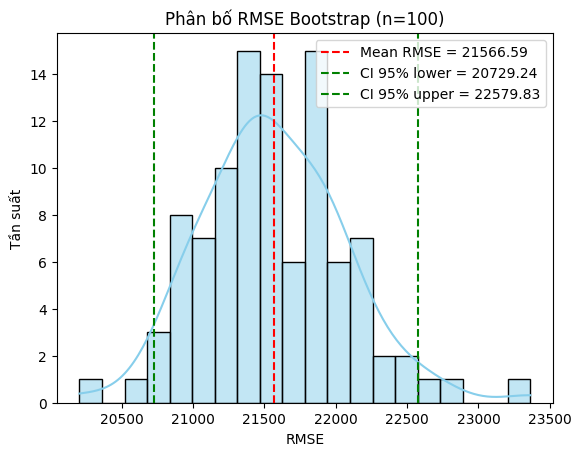

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Giả sử bạn đã có rmse_array từ bootstrap
sns.histplot(rmse_array, kde=True, bins=20, color='skyblue')
plt.axvline(rmse_array.mean(), color='red', linestyle='--', label=f"Mean RMSE = {rmse_array.mean():.2f}")
plt.axvline(ci_lower, color='green', linestyle='--', label=f"CI 95% lower = {ci_lower:.2f}")
plt.axvline(ci_upper, color='green', linestyle='--', label=f"CI 95% upper = {ci_upper:.2f}")
plt.title("Phân bố RMSE Bootstrap (n=100)")
plt.xlabel("RMSE")
plt.ylabel("Tần suất")
plt.legend()
plt.show()



Linear Regression:
RMSE mean = 21691.00
95% CI = [20853.24, 22875.39]

XGBoost:
RMSE mean = 12589.12
95% CI = [11891.98, 13297.92]


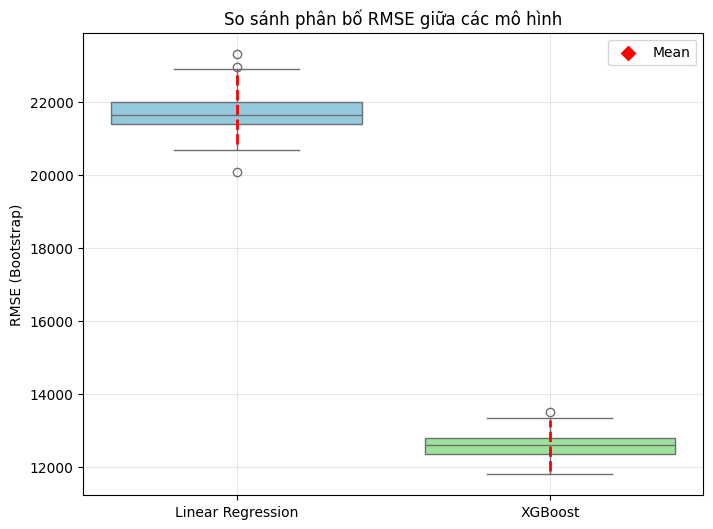

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# --- 1. Đọc dữ liệu ---
df = pd.read_excel("Salary Data.xlsx")

# --- 2. Xử lý dữ liệu ---
df = df.dropna(subset=["Salary"])  # bỏ hàng có Salary NaN
X = df.drop(columns=["Salary"])
y = df["Salary"]

# One-hot encode cho biến phân loại
X = pd.get_dummies(X, drop_first=True)

# Điền giá trị thiếu (nếu có)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Chuẩn hóa
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# --- 3. Khởi tạo mô hình ---
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
}

# --- 4. Hàm bootstrap ---
def bootstrap_rmse(model, X_test, y_test, n_bootstrap=100):
    rmse_list = []
    n_samples = X_test.shape[0]

    for i in range(n_bootstrap):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_sample = X_test[indices]
        y_sample = y_test.iloc[indices].values
        y_pred_sample = model.predict(X_sample)
        rmse = np.sqrt(mean_squared_error(y_sample, y_pred_sample))
        rmse_list.append(rmse)

    rmse_array = np.array(rmse_list)
    ci_lower = np.percentile(rmse_array, 2.5)
    ci_upper = np.percentile(rmse_array, 97.5)
    return rmse_array, rmse_array.mean(), (ci_lower, ci_upper)

# --- 5. Huấn luyện và bootstrap ---
results = {}

for name, model in models.items():
    model.fit(X_scaled_train, y_train)
    rmse_array, rmse_mean, ci = bootstrap_rmse(model, X_scaled_test, y_test)
    results[name] = {
        "rmse_array": rmse_array,
        "mean": rmse_mean,
        "ci_lower": ci[0],
        "ci_upper": ci[1]
    }
    print(f"\n{name}:")
    print(f"RMSE mean = {rmse_mean:.2f}")
    print(f"95% CI = [{ci[0]:.2f}, {ci[1]:.2f}]")

# --- 6. Vẽ boxplot so sánh ---
plt.figure(figsize=(8,6))
sns.boxplot(
    data=[results["Linear Regression"]["rmse_array"], results["XGBoost"]["rmse_array"]],
    palette=["skyblue", "lightgreen"]
)
plt.xticks([0,1], ["Linear Regression", "XGBoost"])
plt.ylabel("RMSE (Bootstrap)")
plt.title("So sánh phân bố RMSE giữa các mô hình")

# Vẽ mean và CI trên boxplot
for i, model_name in enumerate(results.keys()):
    mean = results[model_name]["mean"]
    ci_lower = results[model_name]["ci_lower"]
    ci_upper = results[model_name]["ci_upper"]
    plt.scatter(i, mean, color='red', marker='D', s=50, label="Mean" if i==0 else "")
    plt.vlines(i, ci_lower, ci_upper, color='red', linestyle='--', lw=2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
